# Helmholz equation on a parameter dependent domain (inverse problem)

Solve the scalar Helmholz on a domain (depending on 3 parameters) resembeling a rectangular waveguide. 

Imports

In [106]:
import torch as tn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime
import tikzplotlib
try:
    import torchtt as tntt
except:
    print('Installing torchTT...')
    %pip install git+https://github.com/ion-g-ion/torchtt
    import torchtt as tntt
try:
    import tt_iga
except:
    print('Installing TT-IGA...')
    %pip install git+https://github.com/ion-g-ion/code-paper-tt-iga
    import tt_iga

tn.set_default_dtype(tn.float64)
np.random.seed(42)

## Forward problem

Curves and surfaces parametrizations for the shape

In [107]:
xc = lambda u,v: u*tn.sqrt(1-v**2/2)
yc = lambda u,v: v*tn.sqrt(1-u**2/2)

line = lambda t,a,b: t*(b-a)+a

def plane_spanner(P1,P2,P3,t1,t2):
    x = (P1[:,0]-P2[:,0])*t1+(P3[:,0]-P2[:,0])*t2+P2[:,0]
    y = (P1[:,1]-P2[:,1])*t1+(P3[:,1]-P2[:,1])*t2+P2[:,1]
    z = (P1[:,2]-P2[:,2])*t1+(P3[:,2]-P2[:,2])*t2+P2[:,2]
    return x,y,z

def curve2(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = -1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,-1,-w2)+tn.logical_and(t>=0.5,t<=1)*(-w2)
    y = 0*(t<=0.75) + (t>0.75) * ( -ry*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( rz*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))

def curve1(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = 1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,1,w2)+tn.logical_and(t>=0.5,t<=1)*(w2)
    y = 0*(t<=0.75) + (t>0.75) * ( -ry*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( rz*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))
  
def curve3(t,a,b,c,d):
    w2 = 1.5
    ry = 1.5
    h = 0.5
    rz = 1.5+c
    x = -1*(t<0.25)+tn.logical_and(t>=0.25,t<0.5)*line((t-0.25)/0.25,-1,-w2)+tn.logical_and(t>=0.5,t<=1)*(-w2)
    y = h*(t<=0.75) + (t>0.75) * ( -(ry-h)*tn.cos((t-0.75)/0.25*np.pi/2) + ry )
    z = line(t/0.25,-3,-2+a)*(t<=0.25) + tn.logical_and(t>0.25,t<=0.5)*line((t-0.25)/0.25,-2+a,-1+b) + tn.logical_and(t>0.5,t<=0.75)*line((t-0.5)/0.25,-1+b,-0) + (t>0.75) * ( (rz-h)*tn.sin((t-0.75)/0.25*np.pi/2) )
    return tn.hstack((tn.reshape(x,[-1,1]),tn.reshape(y,[-1,1]),tn.reshape(z,[-1,1])))
      

Define the B-spline bases and the parameter space bases. 
For the parameter space, Gauss-Legendre nodes are used.

In [108]:
deg = 2
Ns = np.array([60,60,120])-deg+1
# Ns = np.array([40,40,82])-deg+1
baza1 = tt_iga.bspline.BSplineBasis(np.linspace(0,1,Ns[0]),deg)
baza2 = tt_iga.bspline.BSplineBasis(np.linspace(0,1,Ns[1]),deg)
baza3 = tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.25,Ns[2]//4),np.linspace(0.25,0.5,Ns[2]//4),np.linspace(0.5,0.75,Ns[2]//4),np.linspace(0.75,1,Ns[2]//4-1))),deg)

Basis = [baza1,baza2,baza3]
N = [baza1.N,baza2.N,baza3.N]

nl = 8
Basis_param = [tt_iga.lagrange.LagrangeLeg(nl,[-0.2,0.2]), tt_iga.lagrange.LagrangeLeg(nl,[-0.3,0.3]), tt_iga.lagrange.LagrangeLeg(nl,[-0.3,0.3])]


Define the parametrization and create the geometry object.

In [109]:
scale_mult = 1
xparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[0]
yparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[1]
zparam = lambda t : plane_spanner(curve1(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve2(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),curve3(t[:,2],scale_mult*t[:,5],scale_mult*t[:,4],scale_mult*t[:,3],0),t[:,0],t[:,1])[2]

# interpolate the geometry parametrization
geom = tt_iga.PatchBSpline.interpolate_geometry([xparam, yparam, zparam], Basis, Basis_param)

Firstly, plot the  geometry for the parameter $\theta_1 = \theta_2 = \theta_3 = 0$.

Secondly, plot the geometries corrrecponding to the edges of the parameter space $[-0.2,0.2] \times [-0.2,0.2] \times [-0.2,0.2]$, i.e. $(\theta_1,\theta_2,\theta_3) \in \{-0.2,0.2\} \times \{-0.2,0.2\} \times \{-0.2,0.2\}$.  

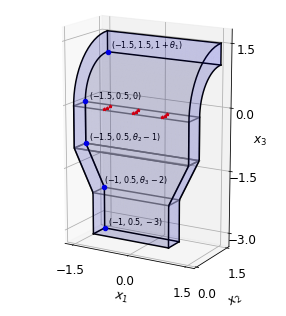

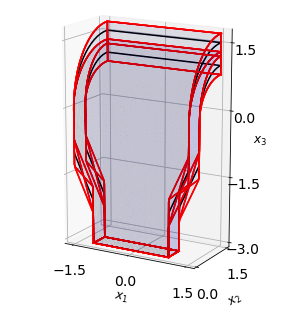

In [110]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
x1 = geom([tn.tensor([0]), tn.tensor([1]), tn.tensor([0,0.25,0.5,0.75,1]),tn.tensor([0]),tn.tensor([0]),tn.tensor([0])])[0].numpy().squeeze()
x2 = geom([tn.tensor([0]), tn.tensor([1]), tn.tensor([0,0.25,0.5,0.75,1]),tn.tensor([0]),tn.tensor([0]),tn.tensor([0])])[1].numpy().squeeze()
x3 = geom([tn.tensor([0]), tn.tensor([1]), tn.tensor([0,0.25,0.5,0.75,1]),tn.tensor([0]),tn.tensor([0]),tn.tensor([0])])[2].numpy().squeeze()
fig.gca().scatter3D(x1[0],x2[0],x3[0],c='blue',s=20)
fig.gca().scatter3D(x1[1],x2[1],x3[1],c='blue',s=20)
fig.gca().scatter3D(x1[2],x2[2],x3[2],c='blue',s=20)
fig.gca().scatter3D(x1[3],x2[3],x3[3],c='blue',s=20)
fig.gca().scatter3D(x1[4],x2[4],x3[4],c='blue',s=20)
fig.gca().text(x1[0]+0.1,x2[0],x3[0]+0.1,r'$(%2g,%2g,%2.1g)$'%(x1[0],x2[0],x3[0]), fontsize = 8)
fig.gca().text(x1[1],x2[1],x3[1]+0.1,r'$(%2g,%2g,\theta_3%2.1g)$'%(x1[1],x2[1],x3[1]), fontsize = 8)
fig.gca().text(x1[2]+0.1,x2[2],x3[2]+0.1,r'$(%2g,%2g,\theta_2%2.1g)$'%(x1[2],x2[2],x3[2]), fontsize = 8)
fig.gca().text(x1[3]+0.1,x2[3],x3[3]+0.1,r'$(%2g,%2g,0)$' %(x1[3],x2[3]), fontsize=8)
fig.gca().text(x1[4]+0.1,x2[4],x3[4]+0.1,r'$(%2g,%2g,%2.1g+\theta_1)$'%(x1[4],x2[4],x3[4]),fontsize=8)
y1, y2, y3 = tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.75])
x1 ,x2 , x3 = geom([y1, y2, y3]+3*[tn.tensor([0])])
x1 = x1.numpy().flatten()
x2 = x2.numpy().flatten()
x3 = x3.numpy().flatten()
for x,y,z in zip(x1,x2,x3):
    fig.gca().scatter3D(x,y,z,c='red',s=10,marker='*')
geom.plot_domain([tn.tensor([0.0]),tn.tensor([-0.0]),tn.tensor([0.0])],[(0,1),(0,1),(0.5,0.75)],fig=fig,surface_color=None, wireframe = False,alpha=0.1,n=64,frame_color='gray')
geom.plot_domain([tn.tensor([0.0]),tn.tensor([-0.0]),tn.tensor([0.0])],[(0,1),(0,1),(0.25,0.5)],fig = fig, surface_color=None, wireframe = False,alpha=0.1,n=64,frame_color='gray')
geom.plot_domain([tn.tensor([0.0]),tn.tensor([-0.0]),tn.tensor([0.0])],[(0,1),(0,1),(0.0,1)],fig = fig, surface_color='blue', wireframe = False,alpha=0.1,n=64,frame_color='k')
fig.gca().set_xlabel(r'$x_1$', fontsize=12)
fig.gca().set_ylabel(r'$x_2$', fontsize=12)
fig.gca().set_zlabel(r'$x_3$', fontsize=12)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1.5])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=12)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))
plt.savefig('./wg_geometry.pdf')
#fig.gca().text()



fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
geom.plot_domain([tn.tensor([0.0]), tn.tensor([-0.0]), tn.tensor([0.0])],[(0,1),(0,1),(0.0,1)], fig = fig, surface_color=None, wireframe = False, alpha = 0.1, n = 64, frame_color = 'k')
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[0]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[0]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[0]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
geom.plot_domain([tn.tensor([Basis_param[0].interval[1]]),tn.tensor([Basis_param[1].interval[1]]), tn.tensor([Basis_param[2].interval[1]]) ],[(0,1),(0,1),(0.0,1)],fig = fig,surface_color='blue', wireframe = False,alpha=0.01,n=64)
fig.gca().set_xlabel(r'$x_1$', fontsize=12)
fig.gca().set_ylabel(r'$x_2$', fontsize=12)
fig.gca().set_zlabel(r'$x_3$', fontsize=12)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1.5])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=14)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))
plt.savefig('./wg_params.pdf')


Construct the stiffness and mass matrix for the entire parameter grid in the TT format.

In [111]:
tme = datetime.datetime.now() 
Mass_tt = geom.mass_interp(Basis, eps=1e-11)
tme = datetime.datetime.now() -tme
print('Time mass matrix ',tme.total_seconds())

tme = datetime.datetime.now() 
Stt = geom.stiffness_interp(Basis, func=None, func_reference = None, qtt = False, verb=False)
tme = datetime.datetime.now() -tme
print('Time stiffness matrix ',tme.total_seconds())

Time mass matrix  0.074759
Time stiffness matrix  1.355893


Get the boundary/interior projection operators.

In [112]:
Pin_tt,Pbd_tt = tt_iga.projectors.get_projectors(N,[[0,0],[0,0],[0,0]])
# Pbd_tt = (1/N[0]) * Pbd_tt

Pin_tt = Pin_tt ** tntt.eye([nl]*3)
Pbd_tt = Pbd_tt ** tntt.eye([nl]*3)

Compute the excitation on the bottom port in TT format. 
The tensor is extended using Kronecker product since the excitation does not change with the parameters.
The boundary projectpor is applied to let only the desired dofs nonzero.

In [113]:
f_tt = tntt.zeros(Stt.N)

excitation_dofs = tt_iga.Function(Basis).interpolate(lambda t: tn.sin(t[:,0]*np.pi)*tn.sin(t[:,1]*np.pi))
tmp = tn.zeros(N)
tmp[:,:,0] = excitation_dofs[:,:,0].full()
g_tt = Pbd_tt@ (tntt.TT(tmp) ** tntt.ones([nl]*3))

Compute the system matrix and include the boundary adaptation.

In [114]:
k = 49

eps_solver = 1e-7
M_tt = (Pin_tt@(Stt-k*Mass_tt)+Pbd_tt).round(1e-12)
rhs_tt = (Pbd_tt @ g_tt).round(1e-12)

M_tt = M_tt.round(1e-11)

Solve the problem (can solve on GPU if one is available) and report ranks, times, memory consumption, etc.

In [115]:
cuda = True
tme_amen = datetime.datetime.now() 
if cuda and tn.cuda.is_available():
    print('Solving in TT (GPU)...')
    dofs_tt = tntt.solvers.amen_solve(M_tt.cuda(), rhs_tt.cuda(), x0 = tntt.ones(rhs_tt.N).cuda(), eps = eps_solver, nswp=40, kickrank=2, verbose=False, preconditioner = 'c', local_iterations=24, resets=10).cpu()
else:
    print('Solving in TT (CPU)...')
    dofs_tt = tntt.solvers.amen_solve(M_tt, rhs_tt, x0 = tntt.ones(rhs_tt.N), eps = eps_solver, nswp=40, kickrank=2, verbose=False, preconditioner = 'c', local_iterations=24, resets=10)
tme_amen = (datetime.datetime.now() -tme_amen).total_seconds() 

print('',flush=True)
print('Time system solve in TT :',tme_amen)
print('Relative residual       :', (M_tt@dofs_tt-rhs_tt).norm()/rhs_tt.norm())
print('N                       :',N)
print('Rank Mtt                :',M_tt.R)
print('Rank rhstt              :',rhs_tt.R)
print('Rank solution           :',dofs_tt.R)
print('size stiff              :',tntt.numel(Stt)*8/1e6,' MB')
print('size mass               :',tntt.numel(Mass_tt)*8/1e6,' MB')
print('size system mat         :',tntt.numel(M_tt)*8/1e6,' MB')
print('size rhstt              :',tntt.numel(rhs_tt)*8/1e6,' MB')
print('size solution           :',tntt.numel(dofs_tt)*8/1e6,' MB, one full solution: ',np.prod(N)*8/1e6,' MB')



Solving in TT (GPU)...

Time system solve in TT : 257.546895
Relative residual       : tensor(1.2972e-06)
N                       : [60, 60, 116]
Rank Mtt                : [1, 6, 20, 12, 6, 8, 1]
Rank rhstt              : [1, 1, 1, 1, 1, 1, 1]
Rank solution           : [1, 60, 81, 81, 66, 10, 1]
size stiff              : 30.360832  MB
size mass               : 0.957824  MB
size system mat         : 29.529856  MB
size rhstt              : 0.00208  MB
size solution           : 8.835232  MB, one full solution:  3.3408  MB


Plot the solution in the reference domain for $(y_1,y_2,y_3)\in[0,1]\times\{0.5\}\times[0,1]$ and $\theta_1=\theta_2=\theta_3=0$.

Text(0, 0.5, '$y_3$')

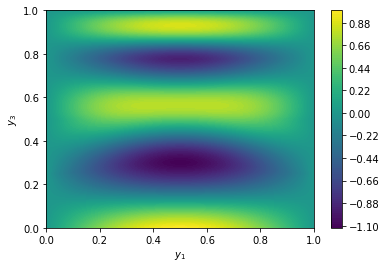

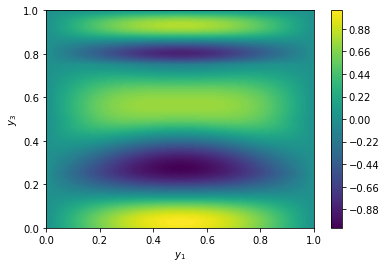

In [116]:
fspace = tt_iga.Function(Basis+Basis_param)
fspace.dofs = dofs_tt

fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([-0.2]),tn.tensor([-0.2]),tn.tensor([-0.2])])
y1, y3 = tn.meshgrid(tn.linspace(0,1,128),tn.linspace(0,1,128))

plt.figure()
plt.contourf(y1, y3, fval.numpy().squeeze(), levels = 128)
plt.colorbar()
plt.xlabel(r'$y_1$')
plt.ylabel(r'$y_3$')

fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.2]),tn.tensor([0.2]),tn.tensor([0.2])])

plt.figure()
plt.contourf(y1, y3, fval.numpy().squeeze(), levels = 128)
plt.colorbar()
plt.xlabel(r'$y_1$')
plt.ylabel(r'$y_3$')


Plot the domain and the solution in the physical domain for $(y_1,y_2,y_3)\in[0,1]\times\{0.5\}\times[0,1]$ and $\theta_1=\theta_2=\theta_3=0$.

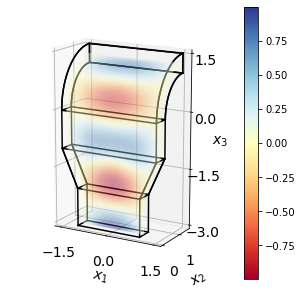

In [117]:
fval = fspace([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.0]),tn.tensor([0.0]),tn.tensor([0.0])])
x,y,z =  geom([tn.linspace(0,1,128),tn.tensor([0.5]),tn.linspace(0,1,128),tn.tensor([0.0]),tn.tensor([0.0]),tn.tensor([0.0])])

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.0,1)],fig = fig,surface_color=None, wireframe = False,frame_color='k',n = 64)
geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.25,0.5)],fig=fig,surface_color=None, wireframe = False,frame_color='k',n = 64)
geom.plot_domain([tn.tensor([0.0])]*3,[(0,1),(0,1),(0.75,1)],fig=fig,surface_color=None, wireframe = False,frame_color='k',n = 64)
import matplotlib.cm

C = fval.numpy().squeeze()
norm = matplotlib.colors.Normalize(vmin=C.min(),vmax=C.max())
C = plt.cm.RdYlBu(norm(C))
C[:,:,-1] = 1
ax.plot_surface(x.numpy().squeeze(), y.numpy().squeeze(), z.numpy().squeeze(), edgecolors=None, linewidth=0, facecolors = C, antialiased=True, rcount=256, ccount=256, alpha=0.5, cmap = 'GnBu')
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().view_init(15, -60)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().set_xticks([-1.5, 0, 1.5])
fig.gca().set_yticks([0,1])
fig.gca().set_zticks([-3,-1.5,0,1.5])
fig.gca().tick_params(axis='both', labelsize=14)
fig.gca().set_box_aspect(aspect = (3,1.5,4.5))
m = matplotlib.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=norm)
m.set_array([])
plt.colorbar(m)
plt.savefig('wg_solution.pdf')


## Inverse problem

First load the measurements from the file

In [118]:
y1, y2, y3 = tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.25, 0.5, 0.75]), tn.tensor([0.75])
x1 ,x2 , x3 = geom([y1, y2, y3]+3*[tn.tensor([0])])
print(x1.numpy().squeeze())
print(x2.numpy().squeeze())
print(x3.numpy().squeeze())

print()
print(fspace([ y1, y2, y3]+3*[tn.tensor([0])]).numpy().squeeze())
import pickle
with open('wg_measurement.pkl', 'rb') as f:
    data = pickle.load(f)

sigma_noise = 0.02
u_noise = data['meas'] + np.random.normal(0, sigma_noise, size = data['meas'].shape)

print(data['meas'])

# x,y,z = geom([tn.tensor([0.5]), tn.tensor([0.5]), tn.tensor([0.75]), tn.linspace(-0.2,0.2,10), tn.linspace(-0.2,0.2,10), tn.linspace(-0.3,0.3,10)])
# 
# get_y3 = lambda p: -0.25*0.5/(1-p)+0.75
# print(np.std(x.numpy()), np.std(y.numpy()), np.std(z.numpy()))
# print(z.numpy()[0,0,0,:,:,:].min(),z.numpy()[0,0,0,0,:,:].max())
# 
# 
# for p in np.linspace(-0.2,0.2,10):
#     y3 = get_y3(p)
#     x,y,z = geom([tn.tensor([0.5]), tn.tensor([0.5]), tn.tensor([y3]), tn.linspace(-0.2,0.2,10), tn.tensor([p]), tn.linspace(-0.3,0.3,10)])
#     print(np.std(x.numpy()), np.std(y.numpy()), np.std(z.numpy()),np.mean(z.numpy()))


[[-7.50000000e-01 -7.50000000e-01 -7.50000000e-01]
 [-1.48709726e-17 -1.48709726e-17 -1.48709726e-17]
 [ 7.50000000e-01  7.50000000e-01  7.50000000e-01]]
[[0.125 0.25  0.375]
 [0.125 0.25  0.375]
 [0.125 0.25  0.375]]
[[5.80644775e-16 4.42819288e-16 3.04993802e-16]
 [5.80644775e-16 4.42819288e-16 3.04993802e-16]
 [5.80644775e-16 4.42819288e-16 3.04993802e-16]]

[[-0.17152379 -0.25502046 -0.19047189]
 [-0.3254789  -0.48022881 -0.35581662]
 [-0.17152308 -0.25501944 -0.19047116]]
[[-0.17160485 -0.25513911 -0.19055893]
 [-0.32557508 -0.48036638 -0.35591617]
 [-0.1716053  -0.25513976 -0.1905594 ]]


In [119]:

def likelihood_handle(params):

    s = tn.zeros((params.shape[0],))

    for i in range(3):
        for j in range(3):
            argz = tn.hstack((y1[i]+tn.zeros((params.shape[0],1)), y2[j]+tn.zeros((params.shape[0],1)) ,y3[0]+tn.zeros((params.shape[0],1)), params))
            u = fspace(argz)
            

            s = s + (u - u_noise[i,j])**2
    
    return tn.exp(-0.5*s /sigma_noise**2 )
        




def prior_handle(params):
    # return tn.ones((params.shape[0],))
    alpha = 4
    beta = 4
    scale = lambda p,v: (p+v)/2/v
    p1 = scale(params[:,0], Basis_param[0].interval[0])**(alpha-1)*(1-scale(params[:,0], Basis_param[0].interval[0]))**(beta-1)
    p2 = scale(params[:,1], Basis_param[1].interval[0])**(alpha-1)*(1-scale(params[:,1], Basis_param[1].interval[0]))**(beta-1)
    p3 = scale(params[:,2], Basis_param[2].interval[0])**(alpha-1)*(1-scale(params[:,2], Basis_param[2].interval[0]))**(beta-1)
    return p1*p2*p3
    #return tn.exp(-1/(2*var*var)*(params[:,0]**2+params[:,1]**2+params[:,2]**2+params[:,3]**2))

def posterior_handle(params):
    print(params.shape)
    return prior_handle(params)* likelihood_handle(params)#+1e-101*(params[...,0]+params[...,1]+params[...,2]+params[...,3])
    # return tn.tensor(list(map((post), list(params))))



In [120]:

import TTCME


basis = [ TTCME.basis.BSplineBasis(64,[Basis_param[i].interval[0],Basis_param[i].interval[1]],2) for i in range (3) ]
xs = tntt.meshgrid([tn.tensor(b.interpolation_pts[0]) for b in basis])
Mg = tntt.rank1TT([tn.tensor(b.interpolation_pts[1]) for b in basis])

paramz = tn.hstack(( tn.reshape(xs[0].full(),[-1,1]) , tn.reshape(xs[1].full(),[-1,1]) , tn.reshape(xs[2].full(),[-1,1])  ))

vals = tn.reshape(posterior_handle(paramz),[b.dim for b in basis])

posterior_pdf = TTCME.pdfTT(basis, variable_names= ['theta1', 'theta2', 'theta3'], dofs = tntt.TT(vals,eps = 1e-12))
# posterior_pdf = TTCME.pdfTT.interpoalte(posterior_handle, basis, variable_names=['theta1', 'theta2', 'theta3', 'theta4'])
print(posterior_pdf)
# 
prior_pdf = TTCME.pdfTT.interpoalte(prior_handle, basis, variable_names=['theta1', 'theta2', 'theta3'])

torch.Size([262144, 3])
Probability density function:
p(theta1,theta2,theta3)

Basis:
B-spline basis defined on [-0.2, 0.2] and dimension 64
B-spline basis defined on [-0.3, 0.3] and dimension 64
B-spline basis defined on [-0.3, 0.3] and dimension 64

DoF:
TT with sizes and ranks:
N = [64, 64, 64]
R = [1, 12, 24, 1]

Device: cpu, dtype: torch.float64
#entries 20736 compression 0.0791015625



In [121]:
posterior_pdf.normalize()

E = posterior_pdf.expected_value()
C = posterior_pdf.covariance_matrix()
V = np.diag(C)

print()
print('Exact parameters:                 ',[0,0,0])
print('')
print('Expected value computed posterior ' ,E)
print('Variance computed posterior       ' ,V)


Exact parameters:                  [0, 0, 0]

Expected value computed posterior  [tensor(0.0066), tensor(-0.0335), tensor(-0.0031)]
Variance computed posterior        [5.44267388e-05 5.59727964e-03 9.64360352e-03]


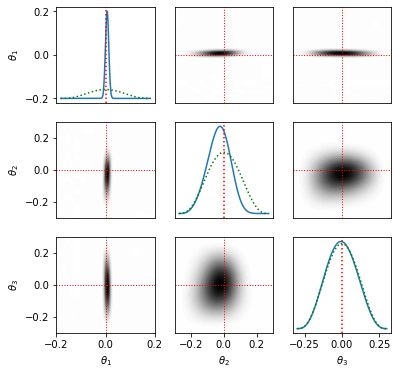

In [122]:
plt.figure(figsize = [6,6])
true_parameters = [0.0]*3
k = 0
for i in range(3):
    for j in range(3):
        k += 1
        if i==j:
            plt.subplot(3, 3, k)
            
            theta = np.linspace(basis[i].domain[0], basis[i].domain[1],1000)
            pr = prior_pdf.marginal([k for k in range(4) if i!=k])[theta].numpy()
            po = posterior_pdf.marginal([k for k in range(4) if i!=k])[theta].numpy()
           
            plt.plot(theta,(po/np.max(po)*(np.max(theta)-np.min(theta))+np.min(theta)))
            plt.axvline(true_parameters[i],c='r',linestyle=':')
            plt.plot(theta,(pr/np.max(po)*(np.max(theta)-np.min(theta))+np.min(theta)),'g:')
            
        else:
            plt.subplot(3, 3, k)
             
            if j<i: 
                theta1 = np.linspace(basis[j].domain[0], basis[j].domain[1], 127)
                theta2 = np.linspace(basis[i].domain[0], basis[i].domain[1], 128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                plt.contourf(T1, T2, po, cmap='gray_r', levels =64)
                plt.axvline(true_parameters[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(true_parameters[i],c='r',linestyle=':',linewidth=1)
            else: 
                theta1 = np.linspace(basis[i].domain[0],basis[i].domain[1],127)
                theta2 = np.linspace(basis[j].domain[0],basis[j].domain[1],128)
                
                T1, T2 = np.meshgrid(theta1, theta2)
                po = posterior_pdf.marginal([k for k in range(4) if i!=k and j!=k])
                po.normalize()
                po = po[theta1,theta2].numpy().T
                plt.contourf(T2, T1, po, cmap='gray_r', levels =64)
                plt.axvline(true_parameters[j],c='r',linestyle=':',linewidth=1)
                plt.axhline(true_parameters[i],c='r',linestyle=':',linewidth=1)
        
        if i==2: plt.xlabel(r'$\theta_'+str(j+1)+'$')
        if j==0: plt.ylabel(r'$\theta_'+str(i+1)+'$')
        
        if j>0: plt.yticks([])
        if i<2: plt.xticks([])

plt.savefig('wg_posterior1.pdf')
